# Run spectra gene program methods in cross-sectional ALTRA data

In [1]:
#import packages
import numpy as np
import json 
import scanpy as sc
import seaborn as sns
from matplotlib import pyplot as plt
from collections import OrderedDict
import scipy 
import pandas as pd
import pickle
#spectra imports 
import Spectra as spc
from Spectra import Spectra_util as spc_tl
from Spectra import K_est as kst
from Spectra import default_gene_sets
from scipy.sparse import csr_matrix, issparse

In [2]:
# define working path
data_path = '/home/jupyter/data/ra_longitudinal/scrna/certPro/'
fig_path = '/home/jupyter/data/ra_longitudinal/figures/Spectra/'
meta_path = '/home/jupyter/github/ra-longitudinal/metadata/'
output_path = '/home/jupyter/data/ra_longitudinal/output_results/Spectra/'

# define a project name
proj_name = 'RA_Cross_sectional_scRNA_Spectra'
# sc.set_figure_params(fig_path)
sc.settings.figdir = fig_path
sc.settings.autosave=False
sc.set_figure_params(vector_friendly=True, dpi_save=300)

# Analyze Spectra results

In [3]:
# load the dataset
crox_sub_adata = sc.read_h5ad(data_path + 'ALTRA_AIM1_2_crox_scRNA_filtered_cell_downsample.h5ad')
crox_sub_adata

AnnData object with n_obs × n_vars = 560208 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'sample.diseaseStatesRecordedAtVisit', 'sample.daysSinceFirstVisit', 'file.id', 'subset_grp', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L1_score', 'AIFI_L2', 'AIFI_L2_score', 'AIFI_L3', 'AIFI_L3_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden_harmony_2', 'doublets_manual', 'AIFI_L3_new', 'St

In [4]:
# load the model
with open(output_path + 'ALTRA_AIM1_2_crox_scRNA_downsample_spectra_model.pickle', 'rb') as f:
    model = pickle.load(f)

In [5]:
#explore eta parameter to detect new factors
len(model.return_eta_diag())

223

In [6]:
#find the factors under adata.uns['SPECTRA_factors'] 
crox_sub_adata.uns['SPECTRA_factors'].shape

(223, 6347)

In [7]:
crox_sub_adata.obs['AIFI_L2'].unique().astype('str')

array(['Memory CD4 T cell', 'Memory B cell', 'Naive CD4 T cell',
       'CD14 monocyte', 'gdT', 'Memory CD8 T cell', 'CD56dim NK cell',
       'pDC', 'CD16 monocyte', 'Naive B cell', 'MAIT', 'Effector B cell',
       'Treg', 'Naive CD8 T cell', 'CD56bright NK cell', 'cDC2',
       'Erythrocyte', 'Proliferating NK cell', 'DN T cell', 'Platelet',
       'Transitional B cell', 'ILC', 'Plasma cell',
       'Intermediate monocyte', 'Progenitor cell', 'Proliferating T cell',
       'cDC1', 'CD8aa', 'ASDC'], dtype='<U21')

In [8]:
# so you can construct a dataframe for the factor gene weights
# include cell type specificity as a prefix into the index
index_labels = crox_sub_adata.uns['SPECTRA_overlap'].index
gene_weights = pd.DataFrame(crox_sub_adata.uns['SPECTRA_factors'], 
                            index = index_labels,
                            columns = crox_sub_adata.var[crox_sub_adata.var['spectra_vocab']].index).transpose()
gene_weights

,0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis,1-X-global-X-all_retinol_metabolism,2-X-global-X-all_RIG-I-like-receptor_signaling,3-X-global-X-all_propanoate_metabolism,4-X-global-X-all_p53-signaling,5-X-global-X-all_macroautophagy,6-X-global-X-all_circadian-rhythm,7-X-global-X-all_VAL-LEU-ILE_metabolism,8-X-global-X-all_taurine-hypotaurine_metabolism,9-X-global-X-all_microautophagy-lysosomal,...,213-X-Treg-X-TNK_IL2-STAT5-signaling,214-X-Treg-X-Treg_FoxP3-stabilization,215-X-Treg-X-CD4-T_TH22_UP,216-X-Treg-X-216,217-X-Treg-X-217,218-X-gdT-X-TNK_cytotoxicity-effectors,219-X-mono-X-all_TNF-via-NFkB_signaling,220-X-mono-X-220,221-X-mono-X-221,222-X-mono-X-all_DNA-demethylation
FAM41C,8.375776e-16,3.779302e-15,9.932433e-16,1.178150e-15,9.086410e-16,5.330064e-16,1.004214e-15,8.322381e-16,2.970326e-15,7.265850e-16,...,1.212272e-03,1.917657e-11,1.151275e-08,1.057835e-03,0.037642,0.012487,1.569990e-10,8.267860e-04,2.759593e-03,0.003204
ISG15,3.046103e-14,8.249192e-14,4.493381e-03,9.817519e-14,2.005391e-14,2.463410e-14,5.960023e-14,6.037471e-14,1.157622e-15,4.108409e-15,...,2.066785e-09,3.615304e-12,1.527407e-02,1.339112e-02,0.000056,0.037229,1.439293e-13,1.502581e-13,8.126815e-12,0.002142
TNFRSF18,3.366851e-16,4.110050e-16,4.023495e-16,6.936347e-16,4.552718e-16,2.465864e-16,5.659576e-16,3.870110e-16,3.859068e-16,3.245276e-16,...,1.050831e-02,7.897715e-09,3.012729e-02,6.896984e-03,0.000098,0.008664,1.077570e-14,1.344668e-15,2.927952e-15,0.000398
TNFRSF4,8.473794e-14,1.388141e-13,6.277845e-14,1.056513e-13,4.186695e-14,1.687665e-14,1.642458e-13,1.133664e-13,2.064433e-14,7.870529e-15,...,1.785871e-02,5.211456e-04,2.152280e-05,1.273061e-02,0.005520,0.004205,6.710162e-15,2.933707e-15,2.839771e-15,0.000333
B3GALT6,4.182406e-02,1.694247e-13,4.791173e-14,1.044946e-11,9.508932e-12,3.650819e-14,1.367095e-13,1.084235e-10,5.307352e-14,3.684511e-13,...,4.750036e-14,3.360701e-14,5.484951e-14,1.437800e-14,0.001271,0.007501,9.721312e-13,1.886484e-03,2.414606e-03,0.011228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRMT2,1.269570e-10,9.617589e-11,5.701625e-11,7.464629e-11,2.752266e-03,2.708726e-12,2.596298e-10,3.809108e-10,2.831224e-04,2.920803e-05,...,7.648241e-13,2.043774e-04,2.246948e-12,3.174998e-11,0.077446,0.050370,4.945067e-12,2.705856e-03,1.157653e-03,0.036258
MT-ND2,1.039872e-10,5.254299e-11,1.738939e-08,2.475877e-09,1.128429e-03,6.771536e-09,3.518473e-10,6.127306e-09,3.167592e-04,1.392107e-04,...,2.262230e-03,1.950603e-03,3.092679e-09,4.060271e-07,0.035983,0.045782,2.294108e-03,2.103211e-02,2.119187e-04,0.053530
MT-ATP8,1.551038e-09,8.996432e-10,7.343886e-08,4.643289e-09,3.353628e-09,1.936801e-08,3.746678e-06,4.596475e-08,6.372861e-09,2.954783e-09,...,3.787977e-15,1.299607e-14,4.943545e-15,4.614384e-14,0.000474,0.022157,1.648405e-03,8.484438e-03,8.297594e-12,0.155054
MT-ND4,1.522552e-11,3.063220e-12,1.134110e-08,3.743116e-10,8.169399e-04,5.075516e-09,2.202556e-10,2.714848e-09,3.427822e-04,2.122398e-04,...,3.236486e-03,4.150408e-03,1.365387e-07,5.299038e-05,0.028738,0.073939,1.368366e-03,1.485056e-02,2.177325e-05,0.057705


In [9]:
gene_weights.to_csv(output_path+proj_name+'_gene_weight.csv')

In [ ]:
# extract the results
factors = crox_sub_adata.uns['SPECTRA_factors'] # factors x genes matrix that tells you how important each gene is to the resulting factors
markers = crox_sub_adata.uns['SPECTRA_markers'] # factors x n_top_vals list of n_top_vals top markers per factor
cell_scores = crox_sub_adata.obsm['SPECTRA_cell_scores'] # cells x factors matrix of cell scores
vocab = crox_sub_adata.var['spectra_vocab'] # boolean matrix of size # of genes that indicates the set of genes used to fit spectra 

In [ ]:
crox_sub_adata

In [66]:
# run a umap based on the scores
sc.pp.neighbors(crox_sub_adata, use_rep='SPECTRA_cell_scores')
sc.tl.umap(crox_sub_adata)

/home/jupyter/libs/Spectra/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


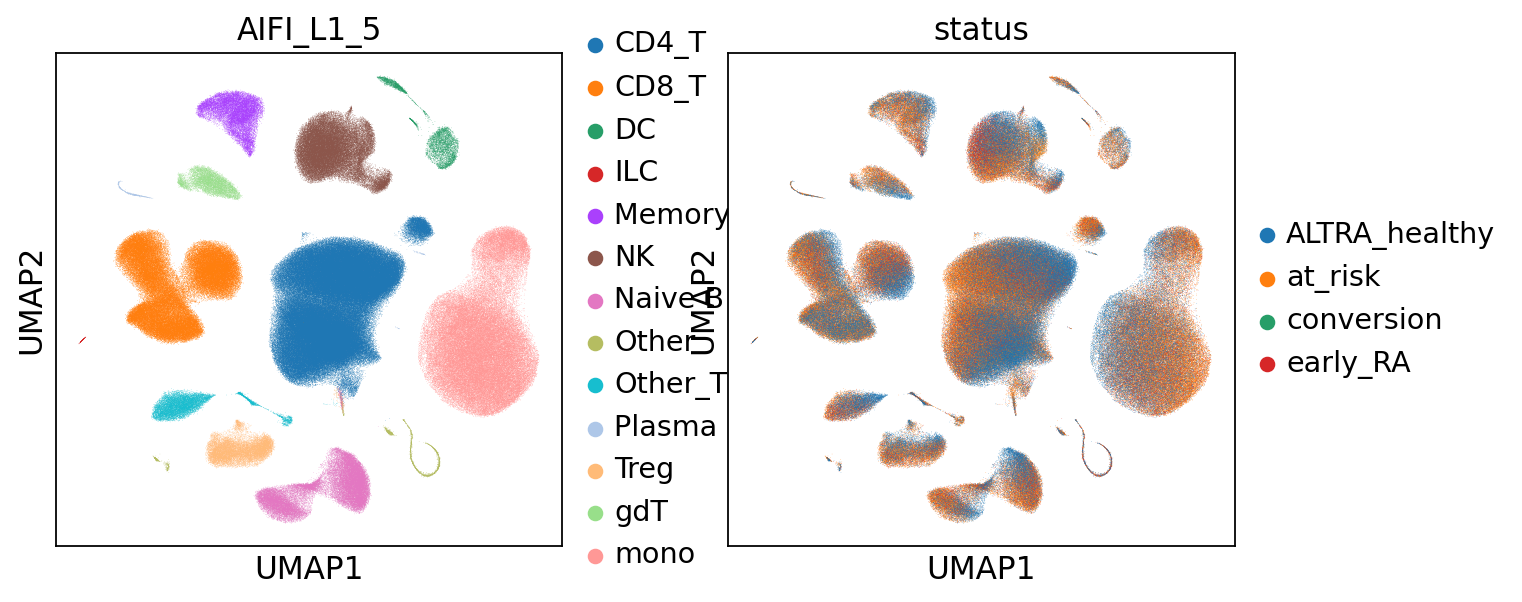

In [68]:
sc.pl.umap(
    crox_sub_adata,
    color=["AIFI_L1_5", 'status']
)

In [15]:
#find an array of the marker genes per factor here:
crox_sub_adata.uns['SPECTRA_markers'].shape

(223, 50)

In [16]:
#find an array of cell scores per factor and cell here:
crox_sub_adata.obsm['SPECTRA_cell_scores'].shape

(560208, 223)

In [17]:
#find the vocab here:
crox_sub_adata.var['spectra_vocab']

MIR1302-2HG    False
FAM138A        False
OR4F5          False
AL627309.1     False
AL627309.3     False
               ...  
AC233755.2     False
AC233755.1     False
AC240274.1     False
AC213203.1     False
FAM231C        False
Name: spectra_vocab, Length: 33538, dtype: bool

In [18]:
#find the factor numbere dict here:
crox_sub_adata.uns['SPECTRA_L']

{'CD4_T': 11,
 'CD8_T': 8,
 'DC': 7,
 'ILC': 5,
 'Memory B cell': 6,
 'NK': 6,
 'Naive B cell': 6,
 'Other': 1,
 'Other_T': 4,
 'Plasma cell': 5,
 'Treg': 8,
 'gdT': 1,
 'global': 151,
 'mono': 4}

In [21]:
markers[198, :]

array(['IGKC', 'IGHM', 'TCL1A', 'MS4A1', 'IGHD', 'CD79A', 'CD79B',
       'BANK1', 'FCER2', 'VPREB3', 'LINC00926', 'CD40', 'HLA-DRA', 'LTB',
       'PLPP5', 'HLA-DOB', 'MEF2C', 'NCF1', 'TNFRSF13C', 'CD74',
       'HLA-DQA1', 'EAF2', 'TSPAN13', 'FAM30A', 'PKIG', 'IL4R', 'SWAP70',
       'BTG1', 'JUN', 'CXCR4', 'PDLIM1', 'RPS12', 'RPL11', 'BIRC3',
       'STX7', 'RPL12', 'HLA-DQB1', 'HLA-DRB1', 'KLF2', 'RPL18', 'HHEX',
       'EEF1A1', 'CD200', 'LAPTM5', 'FTH1', 'CYBA', 'BTK', 'PLEKHF2',
       'FADS3', 'RPS14'], dtype=object)

In [22]:
crox_sub_adata.uns['SPECTRA_overlap'].index[crox_sub_adata.uns['SPECTRA_overlap'].index.str.contains('global')]

Index(['0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis',
       '1-X-global-X-all_retinol_metabolism',
       '2-X-global-X-all_RIG-I-like-receptor_signaling',
       '3-X-global-X-all_propanoate_metabolism',
       '4-X-global-X-all_p53-signaling', '5-X-global-X-all_macroautophagy',
       '6-X-global-X-all_circadian-rhythm',
       '7-X-global-X-all_VAL-LEU-ILE_metabolism',
       '8-X-global-X-all_taurine-hypotaurine_metabolism',
       '9-X-global-X-all_microautophagy-lysosomal',
       ...
       '141-X-global-X-all_folate_metabolism',
       '142-X-global-X-all_CYP_metabolism',
       '143-X-global-X-all_NOD-like-receptor_signaling',
       '144-X-global-X-all_eicosanoid_metabolism',
       '145-X-global-X-all_fatty-acid-beta-oxidation-mitochondrial',
       '146-X-global-X-all_posttranslation-modification',
       '147-X-global-X-all_transmembrane-transport-cellmembrane',
       '148-X-global-X-all_actin-cytoskeleton_regulation',
       '149-X-global-X-all_pentose-p

In [23]:
crox_sub_adata.uns['SPECTRA_overlap'].index

Index(['0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis',
       '1-X-global-X-all_retinol_metabolism',
       '2-X-global-X-all_RIG-I-like-receptor_signaling',
       '3-X-global-X-all_propanoate_metabolism',
       '4-X-global-X-all_p53-signaling', '5-X-global-X-all_macroautophagy',
       '6-X-global-X-all_circadian-rhythm',
       '7-X-global-X-all_VAL-LEU-ILE_metabolism',
       '8-X-global-X-all_taurine-hypotaurine_metabolism',
       '9-X-global-X-all_microautophagy-lysosomal',
       ...
       '213-X-Treg-X-TNK_IL2-STAT5-signaling',
       '214-X-Treg-X-Treg_FoxP3-stabilization', '215-X-Treg-X-CD4-T_TH22_UP',
       '216-X-Treg-X-216', '217-X-Treg-X-217',
       '218-X-gdT-X-TNK_cytotoxicity-effectors',
       '219-X-mono-X-all_TNF-via-NFkB_signaling', '220-X-mono-X-220',
       '221-X-mono-X-221', '222-X-mono-X-all_DNA-demethylation'],
      dtype='object', length=223)

In [24]:
crox_sub_adata

AnnData object with n_obs × n_vars = 560208 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'sample.diseaseStatesRecordedAtVisit', 'sample.daysSinceFirstVisit', 'file.id', 'subset_grp', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L1_score', 'AIFI_L2', 'AIFI_L2_score', 'AIFI_L3', 'AIFI_L3_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden_harmony_2', 'doublets_manual', 'AIFI_L3_new', 'St

In [25]:
# add age as metadata
crox_sub_adata.obs['age'] = pd.to_datetime(crox_sub_adata.obs['sample.drawDate']).dt.year - crox_sub_adata.obs['subject.birthYear']

In [26]:
# create the cell scores
SPECTRA_cell_scores = pd.DataFrame(cell_scores, index=crox_sub_adata.obs.index, 
                                   columns=crox_sub_adata.uns['SPECTRA_overlap'].index)
# add metadata
meta_data = crox_sub_adata.obs[['sample.sampleKitGuid', 'Status_Xsec',
                              'BMI', 'subject.biologicalSex',
                              'CMV_Status_Subj', 
                              'status', 'anti_ccp3_finalCombined',
                             'size_factors', 'AIFI_L1_5']]
spec_cell_scores = SPECTRA_cell_scores.merge(meta_data, left_index=True, right_index=True)

In [27]:
SPECTRA_cell_scores

,0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis,1-X-global-X-all_retinol_metabolism,2-X-global-X-all_RIG-I-like-receptor_signaling,3-X-global-X-all_propanoate_metabolism,4-X-global-X-all_p53-signaling,5-X-global-X-all_macroautophagy,6-X-global-X-all_circadian-rhythm,7-X-global-X-all_VAL-LEU-ILE_metabolism,8-X-global-X-all_taurine-hypotaurine_metabolism,9-X-global-X-all_microautophagy-lysosomal,...,213-X-Treg-X-TNK_IL2-STAT5-signaling,214-X-Treg-X-Treg_FoxP3-stabilization,215-X-Treg-X-CD4-T_TH22_UP,216-X-Treg-X-216,217-X-Treg-X-217,218-X-gdT-X-TNK_cytotoxicity-effectors,219-X-mono-X-all_TNF-via-NFkB_signaling,220-X-mono-X-220,221-X-mono-X-221,222-X-mono-X-all_DNA-demethylation
203477,1.670808e-04,5.065465e-11,9.509061e-07,1.983015e-11,0.000774,2.093319e-09,9.547278e-11,1.564465e-11,1.000309e-02,1.563591e-11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000
348583,5.069030e-11,1.409300e-04,1.225764e-08,3.912955e-11,0.000269,1.710635e-04,4.229982e-11,1.259702e-10,4.271827e-11,7.292707e-12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000
1723649,4.005088e-04,1.636427e-04,1.975575e-04,9.029511e-11,0.000471,4.177519e-09,1.708839e-04,1.707792e-08,2.066341e-03,3.824610e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000
1862327,1.487207e-04,1.529510e-04,1.287857e-10,9.443901e-12,0.000976,4.557160e-04,1.108869e-10,3.636999e-10,4.233031e-10,9.513933e-12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000
204928,4.550599e-10,1.100132e-04,2.628816e-04,7.808990e-11,0.000820,8.707925e-11,1.776142e-11,1.738038e-08,2.178821e-03,4.625776e-04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994598,2.533551e-10,2.099095e-04,1.044618e-08,2.573173e-04,0.001050,4.507562e-10,7.776456e-11,2.391789e-04,1.992409e-05,3.015918e-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000
286026,8.415266e-09,9.110147e-05,4.273252e-04,9.608272e-11,0.000329,3.911113e-10,3.205029e-10,9.478310e-09,3.476633e-09,4.153954e-11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000
1181856,2.282093e-07,8.939718e-05,2.092337e-04,9.813213e-05,0.000520,4.028359e-04,1.846231e-04,1.798846e-04,9.789833e-11,3.778391e-04,...,0.0,0.0,0.0,0.0,0.0,0.0,1.197361e-10,0.000017,0.026689,0.039206
286570,9.078679e-05,7.911864e-05,3.033497e-04,2.511140e-11,0.000533,1.017893e-04,8.526104e-05,8.975250e-05,8.370540e-06,1.375955e-03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000


In [28]:
spec_cell_scores.to_csv(output_path+proj_name+'_cell_scores.tsv', sep="\t")

In [29]:
spec_cell_scores.columns[spec_cell_scores.columns.str.contains('oxidative')]

Index(['122-X-global-X-all_oxidative-phosphorylation'], dtype='object')

(0.0, 0.0002)

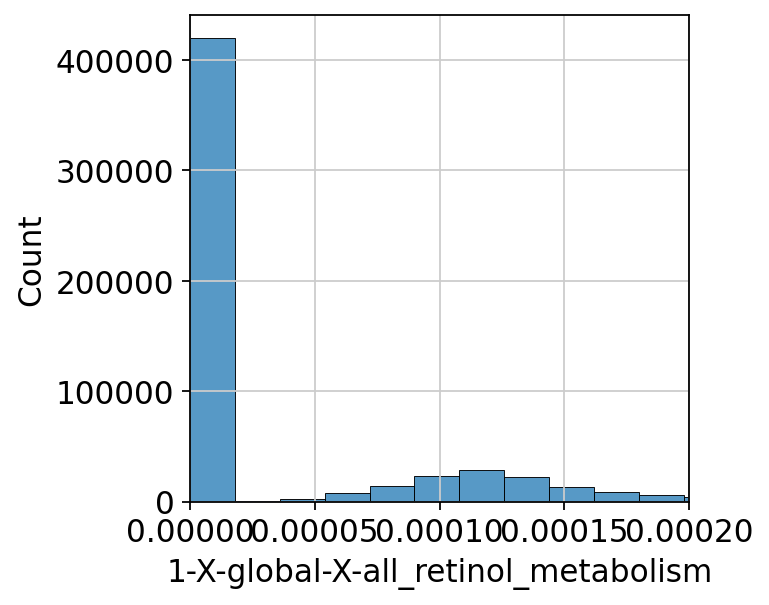

In [30]:
# spec_cell_scores['122-X-global-X-all_oxidative-phosphorylation'].hist(bins=100)
sns.histplot(spec_cell_scores['1-X-global-X-all_retinol_metabolism'],
            bins=50, log_scale=False)
plt.xlim(0, 0.0002)

In [58]:
# run a correlation test for all the factors
SPECTRA_scores_cor = SPECTRA_cell_scores.corr()

In [59]:
SPECTRA_scores_cor.loc[:,['122-X-global-X-all_oxidative-phosphorylation']
    ].sort_values(by='122-X-global-X-all_oxidative-phosphorylation')

,122-X-global-X-all_oxidative-phosphorylation
10-X-global-X-all_transmembrane-transport-ER,-0.226872
62-X-global-X-all_mitophagy_regulation_positive,-0.209825
8-X-global-X-all_taurine-hypotaurine_metabolism,-0.186675
14-X-global-X-all_histone-methylation,-0.186016
199-X-Naive B cell-X-199,-0.183865
...,...
99-X-global-X-99,0.215443
125-X-global-X-all_glycolysis,0.217310
84-X-global-X-all_MYC_targets,0.217588
73-X-global-X-all_mTORC1_signaling,0.234868


In [ ]:
# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(SPECTRA_scores_cor, dtype=bool))

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(80, 80))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(SPECTRA_scores_cor, mask=mask, cmap=cmap,  center=0, robust=True,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5}
#            )

In [ ]:
(crox_sub_adata.obs.index==SPECTRA_cell_scores.index).all()

In [ ]:
SPECTRA_cell_scores.loc[:,SPECTRA_cell_scores.columns.str.contains('CD4')]

In [ ]:
crox_sub_adata.obs['160-X-CD4_T-X-T_IL21_response'] = SPECTRA_cell_scores['160-X-CD4_T-X-T_IL21_response']
crox_sub_adata.obs['122-X-global-X-all_oxidative-phosphorylation'] = SPECTRA_cell_scores['122-X-global-X-all_oxidative-phosphorylation']

In [ ]:
sc.pl.umap(crox_sub_adata, ncols=2,
           color=['122-X-global-X-all_oxidative-phosphorylation', 'subject.biologicalSex',
                              'AIFI_L1_5', 'Status_Xsec'])

In [ ]:
sc.pl.umap(crox_sub_adata[crox_sub_adata.obs['AIFI_L1_5']=='CD4_T'], ncols=2,
           color=['160-X-CD4_T-X-T_IL21_response', 'subject.biologicalSex',
                  'AIFI_L2', 'Status_Xsec'])

In [ ]:
crox_sub_adata.obs['AIFI_L1_5'].unique().astype('str')

In [ ]:
crox_sub_adata.obs['194-X-Naive B cell-X-all_type-II-ifn-response'] = SPECTRA_cell_scores['194-X-Naive B cell-X-all_type-II-ifn-response']

sc.pl.umap(crox_sub_adata[crox_sub_adata.obs['AIFI_L1_5']=='Naive B cell'], 
           ncols=2,
           color=['194-X-Naive B cell-X-all_type-II-ifn-response', 'subject.biologicalSex',
                  'AIFI_L2', 'Status_Xsec'])

## calculate average score per sample

In [85]:
# calculate an average scores
SPECTRA_avg_scores = pd.DataFrame(cell_scores, index=crox_sub_adata.obs.index,
                                  columns=crox_sub_adata.uns['SPECTRA_overlap'].index)
SPECTRA_avg_scores['sample.sampleKitGuid'] = crox_sub_adata.obs['sample.sampleKitGuid']
SPECTRA_avg_scores['AIFI_L1_5'] = crox_sub_adata.obs['AIFI_L1_5']

SPECTRA_avg_scores = SPECTRA_avg_scores.groupby(
    ['sample.sampleKitGuid', 'AIFI_L1_5'], observed=True).mean().reset_index()

# add metadata
meta_data = crox_sub_adata.obs[['sample.sampleKitGuid', 'Status_Xsec', 'Status_Long',
                                'BMI', 'subject.biologicalSex',
                                'CMV_Status_Subj', 'age',
                                'status', 'anti_ccp3_finalCombined']].drop_duplicates()
SPECTRA_avg_scores = SPECTRA_avg_scores.merge(
    meta_data, on=['sample.sampleKitGuid'], how='left')

SPECTRA_avg_scores.to_csv(output_path+proj_name+'SPECTRA_sample_mean_scores.tsv', sep="\t")
SPECTRA_avg_scores

,sample.sampleKitGuid,AIFI_L1_5,0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis,1-X-global-X-all_retinol_metabolism,2-X-global-X-all_RIG-I-like-receptor_signaling,3-X-global-X-all_propanoate_metabolism,4-X-global-X-all_p53-signaling,5-X-global-X-all_macroautophagy,6-X-global-X-all_circadian-rhythm,7-X-global-X-all_VAL-LEU-ILE_metabolism,...,221-X-mono-X-221,222-X-mono-X-all_DNA-demethylation,Status_Xsec,Status_Long,BMI,subject.biologicalSex,CMV_Status_Subj,age,status,anti_ccp3_finalCombined
0,KT00052,CD4_T,8.590671e-05,3.298905e-05,0.000198,0.000004,0.000607,9.747817e-05,6.149963e-05,5.874368e-05,...,0.000000,0.000000,at_risk,pre,24.657159,Female,Negative,56,at_risk,88.0
1,KT00052,CD8_T,9.477700e-05,4.016787e-05,0.000179,0.000005,0.000631,9.320702e-05,6.401234e-05,7.730528e-05,...,0.000000,0.000000,at_risk,pre,24.657159,Female,Negative,56,at_risk,88.0
2,KT00052,DC,1.048606e-04,5.538801e-05,0.000219,0.000053,0.000636,1.554466e-04,8.335178e-05,1.075857e-04,...,0.000000,0.000000,at_risk,pre,24.657159,Female,Negative,56,at_risk,88.0
3,KT00052,ILC,1.869104e-10,4.923916e-11,0.000625,0.000131,0.000656,2.219277e-09,5.302135e-11,1.109622e-08,...,0.000000,0.000000,at_risk,pre,24.657159,Female,Negative,56,at_risk,88.0
4,KT00052,Memory B cell,7.690330e-05,5.087313e-05,0.000139,0.000011,0.000482,1.052477e-04,5.521731e-05,6.673944e-05,...,0.000000,0.000000,at_risk,pre,24.657159,Female,Negative,56,at_risk,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,KT04937,Other_T,2.092583e-04,5.045553e-05,0.000406,0.000011,0.000866,2.751034e-04,1.280511e-04,1.435748e-04,...,0.000000,0.000000,ALTRA_healthy,NaN,28.905868,Female,NaN,74,ALTRA_healthy,6.0
1120,KT04937,Plasma cell,1.477595e-04,7.953275e-05,0.000267,0.000022,0.000480,2.065196e-04,6.882921e-05,2.112970e-04,...,0.000000,0.000000,ALTRA_healthy,NaN,28.905868,Female,NaN,74,ALTRA_healthy,6.0
1121,KT04937,Treg,1.295847e-04,3.111252e-05,0.000259,0.000010,0.000638,2.210234e-04,1.069545e-04,9.533920e-05,...,0.000000,0.000000,ALTRA_healthy,NaN,28.905868,Female,NaN,74,ALTRA_healthy,6.0
1122,KT04937,gdT,1.629663e-04,2.966059e-05,0.000289,0.000007,0.000646,2.091199e-04,1.745899e-04,8.536008e-05,...,0.000000,0.000000,ALTRA_healthy,NaN,28.905868,Female,NaN,74,ALTRA_healthy,6.0


In [37]:
output_path+proj_name+'SPECTRA_sample_average_scores.tsv'

'/home/jupyter/data/ra_longitudinal/output_results/Spectra/RA_Cross_sectional_scRNA_SpectraSPECTRA_sample_average_scores.tsv'

In [52]:
# calculate the precentage of non-zero
pos_threshold = 0.0001
SPECTRA_scores_prec = pd.DataFrame(cell_scores, index=crox_sub_adata.obs.index, 
                                   columns=crox_sub_adata.uns['SPECTRA_overlap'].index)
SPECTRA_scores_prec = (SPECTRA_scores_prec > pos_threshold).sum(axis=0) / len(SPECTRA_scores_prec)
SPECTRA_scores_prec = pd.DataFrame({'nonzero_precentage':SPECTRA_scores_prec})
SPECTRA_scores_prec.to_csv(output_path+proj_name+'_sample_scores_nonzero_precentage.tsv', sep="\t")
SPECTRA_scores_prec

,nonzero_precentage
0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis,0.471018
1-X-global-X-all_retinol_metabolism,0.186738
2-X-global-X-all_RIG-I-like-receptor_signaling,0.641585
3-X-global-X-all_propanoate_metabolism,0.108719
4-X-global-X-all_p53-signaling,0.832516
...,...
218-X-gdT-X-TNK_cytotoxicity-effectors,0.013488
219-X-mono-X-all_TNF-via-NFkB_signaling,0.102646
220-X-mono-X-220,0.108513
221-X-mono-X-221,0.171838


<Axes: xlabel='nonzero_precentage', ylabel='Count'>

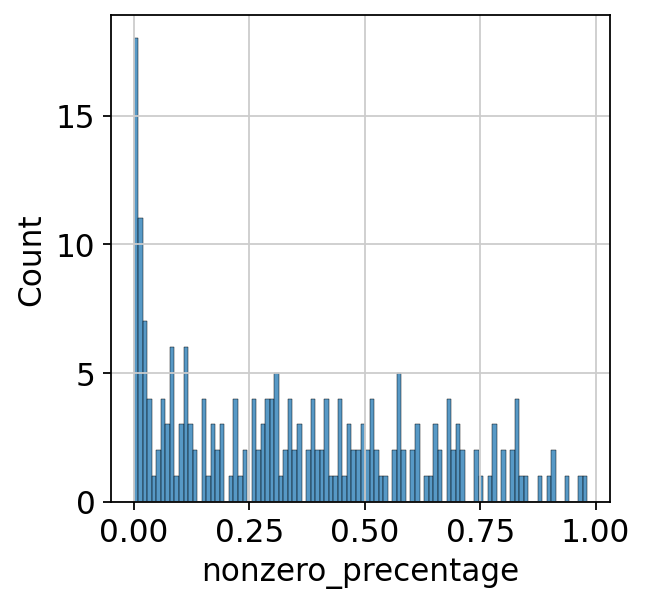

In [53]:
sns.histplot(SPECTRA_scores_prec, x='nonzero_precentage',
            bins=100, log_scale=False)
# plt.xlim(0, 0.1)

In [31]:

# Group by 'Group' column and calculate the percentage of zero values for each group
def calculate_zero_percentage(group):
    zero_percentage = (group >= pos_threshold).sum() / len(group) * 100
    return zero_percentage
    
def calculate_SPECTRA_scores(cell_scores, crox_sub_adata, pos_threshold=0):
    """
    Calculate SPECTRA scores for positive cells and save the results to a file.

    Parameters:
    - cell_scores: DataFrame containing cell scores.
    - crox_sub_adata: AnnData object containing the necessary metadata.
    - pos_threshold: Threshold for positive scores (default is 0).
    - output_path: Path to save the output file.
    - proj_name: Project name to be used in the output file name.

    Returns:
    - SPECTRA_pos_scores_long: DataFrame containing the calculated SPECTRA scores.
    """
    # Calculate an average scores for the positive cells
    SPECTRA_pos_scores = pd.DataFrame(cell_scores, index=crox_sub_adata.obs.index,
                                      columns=crox_sub_adata.uns['SPECTRA_overlap'].index)
    SPECTRA_pos_scores = SPECTRA_pos_scores[SPECTRA_pos_scores >= pos_threshold]
    SPECTRA_pos_scores['sample.sampleKitGuid'] = crox_sub_adata.obs['sample.sampleKitGuid']
    SPECTRA_pos_scores['AIFI_L1_5'] = crox_sub_adata.obs['AIFI_L1_5']
    
    # Add percentage of 0
    SPECTRA_scores_prec = SPECTRA_pos_scores.groupby(['sample.sampleKitGuid', 'AIFI_L1_5'],
                                                     observed=True).apply(calculate_zero_percentage).reset_index()
    
    # Transform SPECTRA_pos_scores into a long format
    SPECTRA_scores_prec_long = pd.melt(SPECTRA_scores_prec,
                                       id_vars=['sample.sampleKitGuid', 'AIFI_L1_5'],
                                       var_name='Spectra_factor',
                                       value_name='nonzero_percentage')
    
    # Calculate mean and replace NA with 0
    SPECTRA_pos_scores = SPECTRA_pos_scores.groupby(['sample.sampleKitGuid', 'AIFI_L1_5'],
                                                    observed=False).mean().fillna(0).reset_index()
    
    # Transform SPECTRA_pos_scores into a long format
    SPECTRA_pos_scores_long = pd.melt(SPECTRA_pos_scores,
                                      id_vars=['sample.sampleKitGuid', 'AIFI_L1_5'],
                                      var_name='Spectra_factor',
                                      value_name='mean_score')
    
    SPECTRA_pos_scores_long = SPECTRA_pos_scores_long.merge(
        SPECTRA_scores_prec_long, on=['sample.sampleKitGuid', 'AIFI_L1_5', 'Spectra_factor'], how='left')
    
    # Add metadata
    meta_data = crox_sub_adata.obs[['sample.sampleKitGuid', 'file.batchID', 'Status_Xsec', 'Status_Long',
                                    'BMI', 'subject.biologicalSex', 'CMV_Status_Subj', 'age',
                                    'status', 'anti_ccp3_finalCombined']].drop_duplicates()
    
    SPECTRA_pos_scores_long = SPECTRA_pos_scores_long.merge(
        meta_data, on=['sample.sampleKitGuid'], how='left')
    
    return SPECTRA_pos_scores_long

# Example usage:
# result = calculate_SPECTRA_scores(cell_scores, crox_sub_adata, pos_threshold=0, output_path='path/to/output/', proj_name='project_name')

In [43]:
SPECTRA_mean_scores = calculate_SPECTRA_scores(cell_scores, crox_sub_adata, pos_threshold=0)
SPECTRA_mean_scores.to_csv(output_path+proj_name +
                          '_sample_mean_scores.tsv', sep="\t")

In [45]:
SPECTRA_mean_scores

,sample.sampleKitGuid,AIFI_L1_5,Spectra_factor,mean_score,nonzero_percentage,file.batchID,Status_Xsec,Status_Long,BMI,subject.biologicalSex,CMV_Status_Subj,age,status,anti_ccp3_finalCombined
0,KT00052,CD4_T,0-X-global-X-all_chondroitine-and-heparan-sulf...,0.000183,44.530245,B140,at_risk,pre,24.657159,Female,Negative,56,at_risk,88.0
1,KT00052,CD8_T,0-X-global-X-all_chondroitine-and-heparan-sulf...,0.000186,47.796143,B140,at_risk,pre,24.657159,Female,Negative,56,at_risk,88.0
2,KT00052,DC,0-X-global-X-all_chondroitine-and-heparan-sulf...,0.000180,46.666667,B140,at_risk,pre,24.657159,Female,Negative,56,at_risk,88.0
3,KT00052,ILC,0-X-global-X-all_chondroitine-and-heparan-sulf...,0.000000,0.000000,B140,at_risk,pre,24.657159,Female,Negative,56,at_risk,88.0
4,KT00052,Memory B cell,0-X-global-X-all_chondroitine-and-heparan-sulf...,0.000178,40.397351,B140,at_risk,pre,24.657159,Female,Negative,56,at_risk,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255107,KT04937,Other_T,222-X-mono-X-all_DNA-demethylation,0.000000,0.000000,B182,ALTRA_healthy,NaN,28.905868,Female,NaN,74,ALTRA_healthy,6.0
255108,KT04937,Plasma cell,222-X-mono-X-all_DNA-demethylation,0.000000,0.000000,B182,ALTRA_healthy,NaN,28.905868,Female,NaN,74,ALTRA_healthy,6.0
255109,KT04937,Treg,222-X-mono-X-all_DNA-demethylation,0.000000,0.000000,B182,ALTRA_healthy,NaN,28.905868,Female,NaN,74,ALTRA_healthy,6.0
255110,KT04937,gdT,222-X-mono-X-all_DNA-demethylation,0.000000,0.000000,B182,ALTRA_healthy,NaN,28.905868,Female,NaN,74,ALTRA_healthy,6.0


In [44]:
SPECTRA_mean_scores = calculate_SPECTRA_scores(cell_scores, crox_sub_adata, pos_threshold=0.0001)
SPECTRA_mean_scores.to_csv(output_path+proj_name +
                          '_sample_average_positive_scores.tsv', sep="\t")

In [42]:


    
# # calculate an average scores for the postive cells
# pos_threshold = 0
# SPECTRA_pos_scores = pd.DataFrame(cell_scores, index=crox_sub_adata.obs.index,
#                                   columns=crox_sub_adata.uns['SPECTRA_overlap'].index)
# SPECTRA_pos_scores = SPECTRA_pos_scores[SPECTRA_pos_scores >= pos_threshold]
# SPECTRA_pos_scores['sample.sampleKitGuid'] = crox_sub_adata.obs['sample.sampleKitGuid']
# SPECTRA_pos_scores['AIFI_L1_5'] = crox_sub_adata.obs['AIFI_L1_5']
# # add precentage of 0
# SPECTRA_scores_prec = SPECTRA_pos_scores.groupby(['sample.sampleKitGuid', 'AIFI_L1_5'],
#                                                 observed=True).apply(calculate_zero_percentage).reset_index()
# # Transform SPECTRA_pos_scores into a long format
# SPECTRA_scores_prec_long = pd.melt(SPECTRA_scores_prec,  
#                                   id_vars=['sample.sampleKitGuid', 'AIFI_L1_5'],
#                                   var_name='Spectra_factor', 
#                                   value_name='nonzero_precentage')
# # # calculate mean and replace na with 0
# SPECTRA_pos_scores = SPECTRA_pos_scores.groupby(['sample.sampleKitGuid', 'AIFI_L1_5'],
#                                                 observed=False).mean().fillna(0).reset_index()

# # Transform SPECTRA_pos_scores into a long format
# SPECTRA_pos_scores_long = pd.melt(SPECTRA_pos_scores,  
#                                   id_vars=['sample.sampleKitGuid', 'AIFI_L1_5'],
#                                   var_name='Spectra_factor', 
#                                   value_name='mean_score')

# SPECTRA_pos_scores_long = SPECTRA_pos_scores_long.merge(
#     SPECTRA_scores_prec_long, on=['sample.sampleKitGuid', 'AIFI_L1_5', 'Spectra_factor'], how='left')
# # add metadata
# meta_data = crox_sub_adata.obs[['sample.sampleKitGuid', 'file.batchID', 'Status_Xsec', 'Status_Long',
#                                 'BMI', 'subject.biologicalSex',
#                                 'CMV_Status_Subj', 'age',
#                                 'status', 'anti_ccp3_finalCombined']].drop_duplicates()
# SPECTRA_pos_scores_long = SPECTRA_pos_scores_long.merge(
#     meta_data, on=['sample.sampleKitGuid'], how='left')

# SPECTRA_pos_scores_long.to_csv(output_path+proj_name +
#                           '_sample_average_positive_scores.tsv', sep="\t")
# SPECTRA_pos_scores_long


In [37]:
SPECTRA_pos_scores_long.shape

(255112, 14)

In [41]:
(SPECTRA_mean_scores['mean_score'] == SPECTRA_pos_scores_long['mean_score']).all()

True

## Accessing the fitted gene-gene graph

In [22]:
soft_graph = model.return_graph(ct = "global")
soft_graph

array([[9.9999970e-01, 2.0675821e-13, 2.6679665e-13, ..., 7.3937258e-06,
        4.6650337e-09, 3.7796439e-03],
       [2.0675821e-13, 1.2535917e-16, 1.2535917e-16, ..., 3.3500573e-13,
        1.9574872e-14, 1.8221853e-13],
       [2.6679665e-13, 1.2535917e-16, 1.2535918e-16, ..., 3.6893359e-13,
        3.0397732e-14, 5.6030338e-13],
       ...,
       [7.3937254e-06, 3.3500570e-13, 3.6893362e-13, ..., 1.5869018e-01,
        2.1078025e-03, 5.9376854e-02],
       [4.6650341e-09, 1.9574884e-14, 3.0397746e-14, ..., 2.1078023e-03,
        1.1933238e-03, 1.5387193e-03],
       [3.7796439e-03, 1.8221857e-13, 5.6030386e-13, ..., 5.9376843e-02,
        1.5387192e-03, 1.4995421e-01]], dtype=float32)

In [24]:
gene_set = list(crox_sub_adata.uns['SPECTRA_markers'][0])
out = spc.graph_network(crox_sub_adata, soft_graph, gene_set)

In [8]:
# out.save(fig_path+"test_graph.html")

## plot the gene of factor of interests

In [9]:
crox_sub_adata

AnnData object with n_obs × n_vars = 560208 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'sample.diseaseStatesRecordedAtVisit', 'sample.daysSinceFirstVisit', 'file.id', 'subset_grp', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L1_score', 'AIFI_L2', 'AIFI_L2_score', 'AIFI_L3', 'AIFI_L3_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden_harmony_2', 'doublets_manual', 'AIFI_L3_new', 'St

PDE3B     0.259218
NECAP2    0.187652
TXK       0.159476
CAMK4     0.155896
PCED1B    0.153318
TESPA1    0.150387
SESN3     0.143542
LEF1      0.142808
IL6ST     0.131298
PDK1      0.119308
Name: 168-X-CD8_T-X-168, dtype: float64


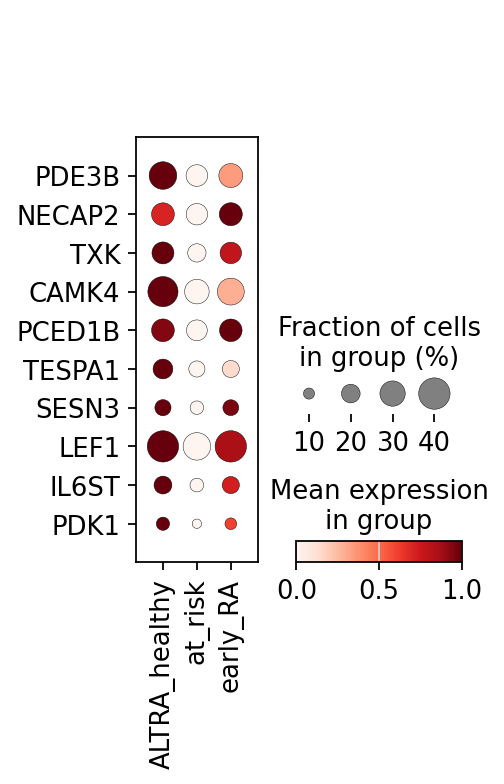

In [98]:
factor_name = '168-X-CD8_T-X-168'
top10_genes = gene_weights.loc[:,factor_name].sort_values(ascending=False).head(10)
print(top10_genes)
sc.pl.dotplot(crox_sub_adata[crox_sub_adata.obs['AIFI_L1_5']=='CD8_T'], top10_genes.index, groupby='Status_Xsec', 
              swap_axes=True, standard_scale='var', save=proj_name+factor_name+'_CD8_T_top10_genes_dotplot.pdf')

ARID5A      0.177487
NDUFV3      0.158349
CYB561D2    0.140487
NSMCE2      0.132786
PI4K2B      0.080015
CD40LG      0.067392
CDC25B      0.056428
LCK         0.049670
FLT3LG      0.047080
LAT         0.042992
Name: 152-X-CD4_T-X-CD4-T_IL4_response, dtype: float64


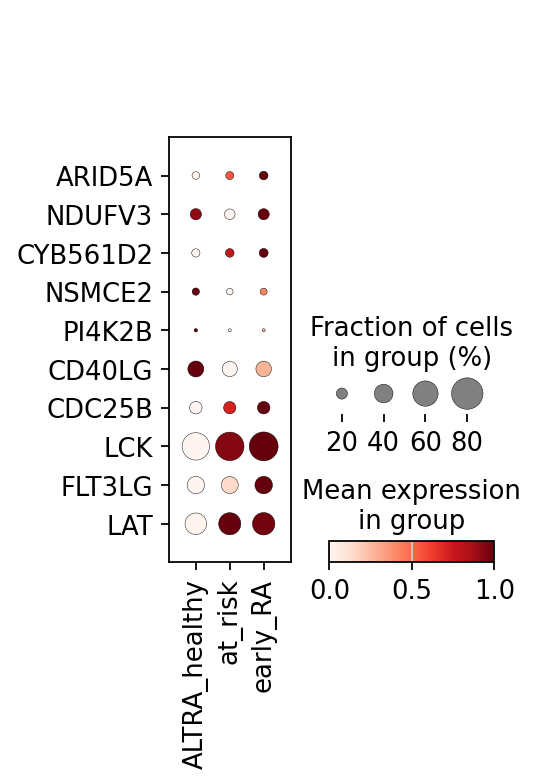

In [11]:
factor_name = '152-X-CD4_T-X-CD4-T_IL4_response'
top10_genes = gene_weights.loc[:,factor_name].sort_values(ascending=False).head(10)
print(top10_genes)
sc.pl.dotplot(crox_sub_adata[crox_sub_adata.obs['AIFI_L1_5']=='CD4_T'], top10_genes.index, groupby='Status_Xsec', 
              swap_axes=True, standard_scale='var', save=proj_name+factor_name+'_top10_genes_dotplot.pdf')

ZBTB32        0.329340
CD1C          0.277805
IGHG2         0.189872
CD82          0.176276
CSGALNACT1    0.171107
ACP5          0.168202
BHLHE41       0.166936
ASAH1         0.150775
GALNT10       0.149704
DOK3          0.125589
Name: 185-X-Memory B cell-X-B_effector-1_UP, dtype: float64


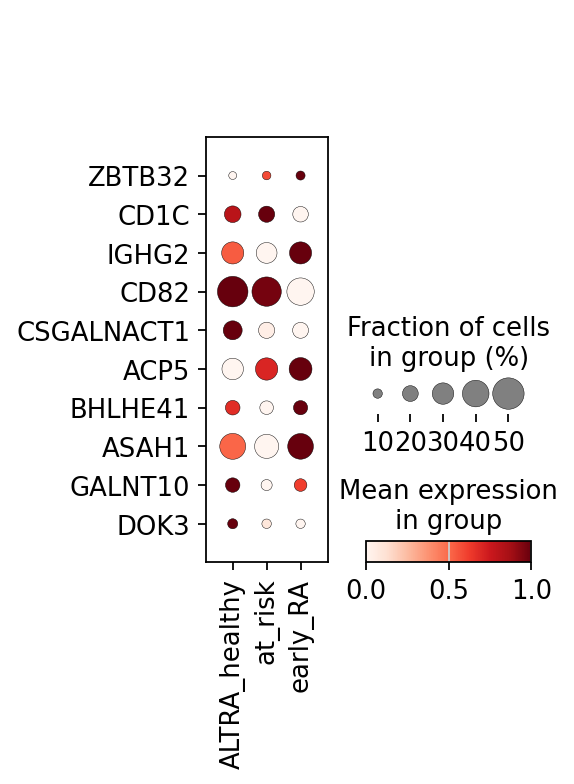

In [12]:
factor_name =  '185-X-Memory B cell-X-B_effector-1_UP'
top10_genes = gene_weights.loc[:,factor_name].sort_values(ascending=False).head(10)
print(top10_genes)
sc.pl.dotplot(crox_sub_adata[crox_sub_adata.obs['AIFI_L1_5']=='Memory B cell'], top10_genes.index, groupby='Status_Xsec', 
              swap_axes=True, standard_scale='var', save=proj_name+factor_name+'_top10_genes_dotplot.pdf')

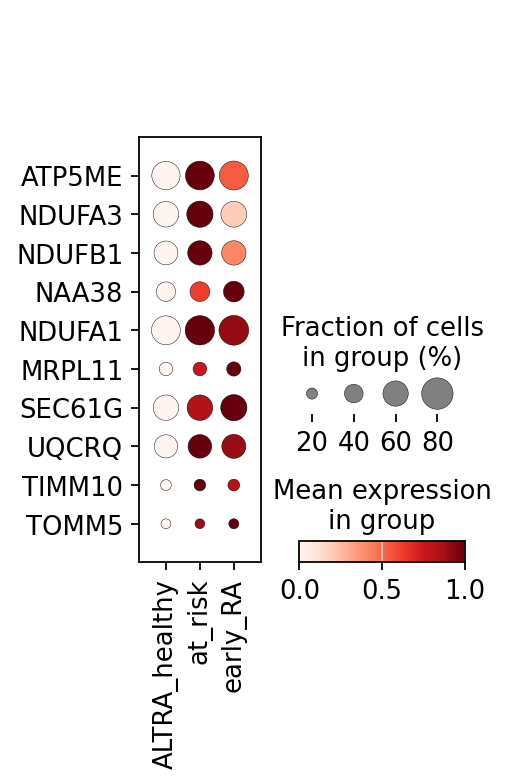

In [88]:
factor_name = '122-X-global-X-all_oxidative-phosphorylation'
top10_genes = gene_weights.loc[:,factor_name].sort_values(ascending=False).head(10)
sc.pl.dotplot(crox_sub_adata, top10_genes.index, groupby='Status_Xsec', 
              swap_axes=True, standard_scale='var', save=proj_name+factor_name+'_top10_genes_dotplot.pdf')

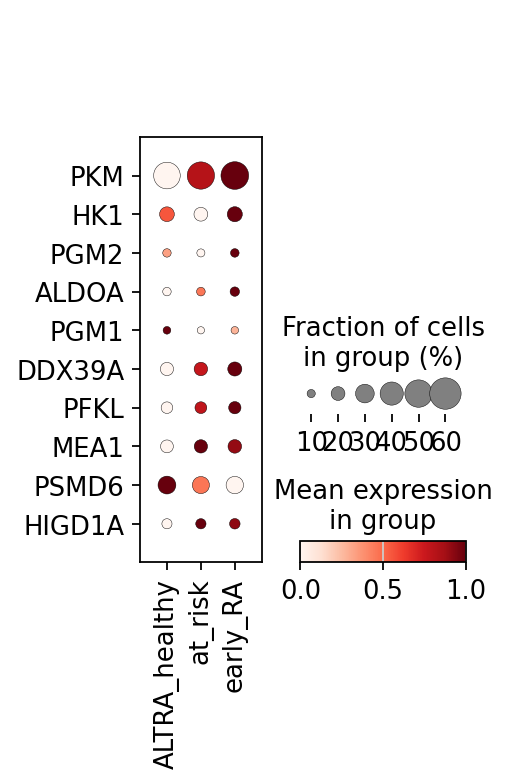

In [13]:
factor_name = '125-X-global-X-all_glycolysis'
top10_genes = gene_weights.loc[:,factor_name].sort_values(ascending=False).head(10)
sc.pl.dotplot(crox_sub_adata, top10_genes.index, groupby='Status_Xsec', 
              swap_axes=True, standard_scale='var', save=proj_name+factor_name+'_top10_genes_dotplot.pdf')

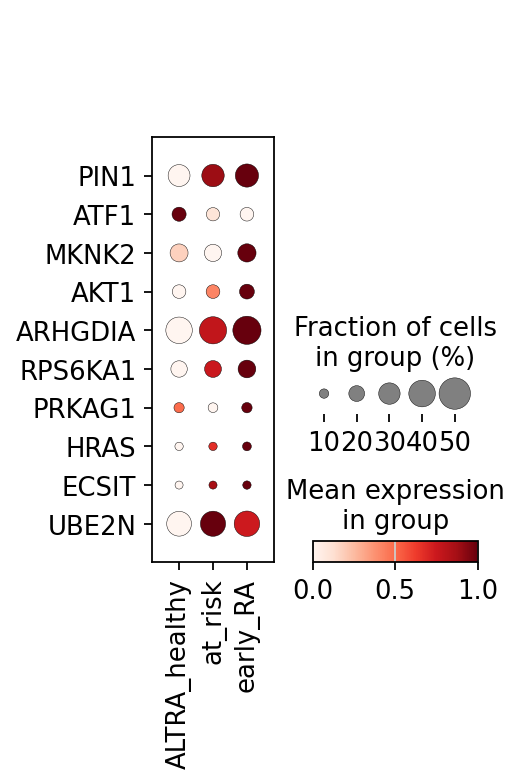

In [13]:
factor_name = '22-X-global-X-all_PI3K-AKT-mTOR_signaling'
top10_genes = gene_weights.loc[:,factor_name].sort_values(ascending=False).head(10)
sc.pl.dotplot(crox_sub_adata, top10_genes.index, groupby='Status_Xsec', 
              swap_axes=True, standard_scale='var', save=proj_name+factor_name+'_top10_genes_dotplot.pdf')